In [25]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string, re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from wordcloud import WordCloud,STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    297
1    140
Name: Sentiment, dtype: int64
0    56
1    22
Name: Sentiment, dtype: int64


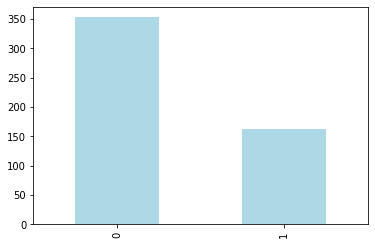

In [26]:
data = pd.read_csv('500tweets.csv')

# Drop column 'id'
data.drop(columns='ID', inplace=True)

#Removing hexcodes
#emoji_pattern = re.compile(r'(\\x(.){2})')
#for i in range(len(data['Text'])):
  #data['Text'][i]=emoji_pattern.sub(r'', data['Text'][i])
#data = data[['Text','Sentiment']]


# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.15)
print(train.Sentiment.value_counts())
print(test.Sentiment.value_counts())

data['Sentiment'].value_counts().plot.bar(color = 'lightblue', figsize = (6, 4))

Positive words


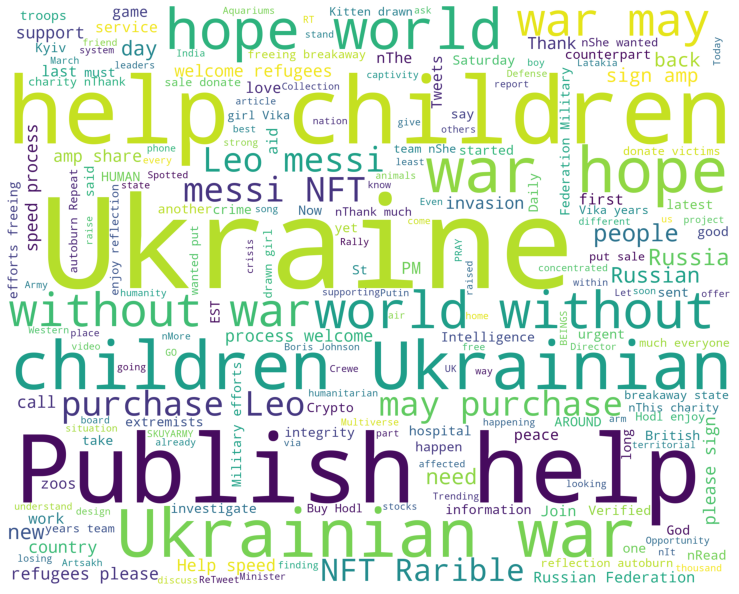

Negative words


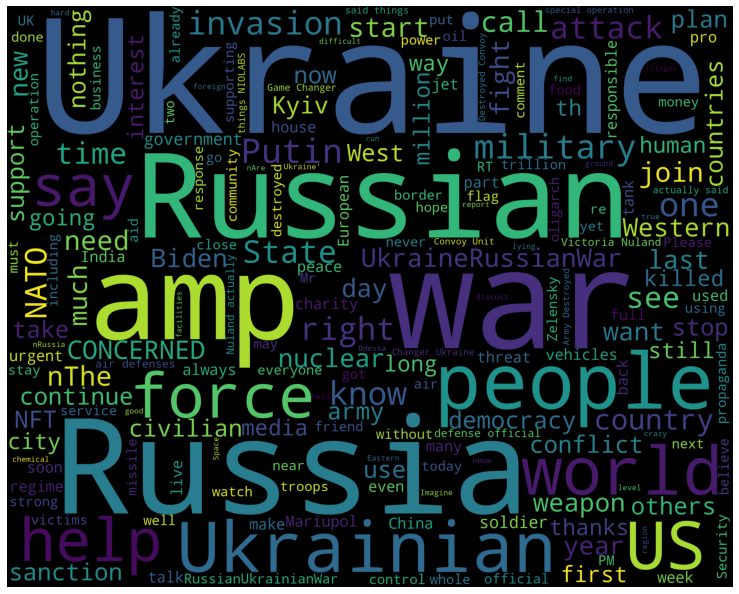

In [27]:
def show_words(data, color = 'black'):
    
    #Removing hexcodes and numbers
    re1=r'(\\x(.){2})'
    re2=r'[0-9]+'
    emoji_pattern = re.compile("(%s|%s)" % (re1, re2))

    for i in range(len(data)):
      data.iloc[i]=emoji_pattern.sub(r'', data.iloc[i])
    
    words = ' '.join(data)
    stops = stopwords.words("english") + list(string.punctuation)
    final = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                                and not word.startswith('b\'')
                                and not word.startswith('b\"')
                                and word not in stops
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(final)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

positive= train[ train['Sentiment'] == 1]
positive = positive['Text']
negative = train[ train['Sentiment'] == 0]
negative = negative['Text']
print("Positive words")
show_words(positive,'white')
print("Negative words")
show_words(negative)

In [28]:
def preprocess(Text):

    #Removing hexcodes
    emoji_pattern = re.compile(r'(\\x(.){2})')
    for i in range(len(Text)):
      Text=emoji_pattern.sub(r'', Text)

    t = TweetTokenizer(strip_handles=True) # remove username handles
    tokens = [token for token in t.tokenize(Text)]
    
    # Combine stopwords and punctuation
    stops = stopwords.words("english") + list(string.punctuation)
    
    l = WordNetLemmatizer()
    
    hashtag = [re.sub(r'#', '', token) for token in tokens]
    stopword = [token.lower() for token in hashtag if token.lower() not in stops]
    url = [re.sub(r'http\S+', '', token) for token in stopword]
    url = [re.sub(r'www\S+', '', token) for token in url]
    extra_space = [re.sub(r'\s\s+', '', token) for token in url]
    alnum = [token for token in extra_space if token.isalnum()]
    lemma = [l.lemmatize(token) for token in alnum]
    final = [token for token in lemma if len(token) > 1]
    
    return final
vectorizer = CountVectorizer(min_df=2)
X_train = vectorizer.fit_transform(train['Text'].apply(preprocess).apply(lambda x:' '.join(x)))
X_test = vectorizer.transform(test['Text'].apply(preprocess).apply(lambda x:' '.join(x)))

In [29]:
# Convertint to numpyarray
y_train = np.array(train['Sentiment'])
y_test = np.array(test['Sentiment'])

model = MultinomialNB() 
model.fit(X_train, y_train)
print('Accuracy:',model.score(X_test, y_test))

Accuracy: 0.7948717948717948


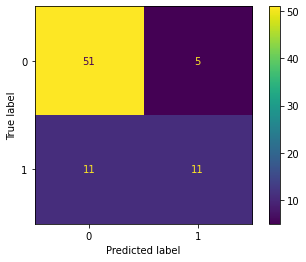

In [30]:
# Generate confusion matrix plot
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()